# Machine learning on rides of 2017

# Preparation and function definitions

### Function to import a CSV with grain data of a ride

In [3]:
# %load training_functions.py
import pandas as pd
import os
import numpy as np
from datetime import datetime

def read_csv_power_file(file_path, filename):
    csv_path = os.path.join(file_path, filename)
    df = pd.read_csv(csv_path)
    
    # Drop columns that we don't need
    df.drop('lat', axis=1, inplace=True)
    df.drop('lon', axis=1, inplace=True)
    df.drop('nm', axis=1, inplace=True)
    df.drop('hhb', axis=1, inplace=True)
    df.drop('o2hb', axis=1, inplace=True)
    df.drop('thb', axis=1, inplace=True)
    df.drop('smo2', axis=1, inplace=True)
    df.drop('rps', axis=1, inplace=True)
    df.drop('lps', axis=1, inplace=True)
    df.drop('rte', axis=1, inplace=True)
    df.drop('lte', axis=1, inplace=True)
    df.drop('headwind', axis=1, inplace=True)
    df.drop('slope', axis=1, inplace=True)
    
    # Replace 0's in columns like cadence
    df['cad'].replace(0, value=np.NaN, inplace=True)
    df['kph'].replace(0, value=np.NaN, inplace=True)
    df['hr'].replace(0, value=np.NaN, inplace=True)
    
    return df


def calculate_height_gain(hd):
    old = hd[0]
    height_gain = 0
    
    for v in hd:
        if v > old:
            height_gain += v-old
        old = v
    
    return height_gain

def normalized_power(pd):
    return np.power(pd.pow(4).sum() / len(pd), 0.25)

def hr_drift(hrd, pd):
    l = len(hrd)/2
    
    first_half = hrd[:l].mean() / pd[:l].mean()
    second_half = hrd[l:].mean() / pd[l:].mean()
    
    return 1 - (first_half / second_half)

def kilojoules(pd):
    return (pd.mean()*len(pd))/1000

def do_aggregations(d, epoch_day, filename):
    df = pd.DataFrame(columns=('filename', 'epoch_day', 'time', 'cad', 'hr', 'hr_min', 'hr_max', 'hr_drift', 
                               'km', 'kph', 'kilojoules', 'watts', 'watts_max', 'watts_std', 'watts_25', 
                               'watts_50', 'watts_75', 'np', 'alt', 'temp', 'lrbalance', 'if'))
    
    alt = calculate_height_gain(d['alt'].values)
    hrdrift = hr_drift(d['hr'], d['watts'])
    
    df.loc[0] = [filename, epoch_day, len(d['hr'])/60, d['cad'].mean(), d['hr'].mean(),d['hr'].min(), 
                 d['hr'].max(), hrdrift, d['km'].max(), d['kph'].mean(), kilojoules(d['watts']), 
                 d['watts'].mean(), d['watts'].max(), d['watts'].std(), d['watts'].quantile(q=0.25), 
                 d['watts'].quantile(q=0.50), d['watts'].quantile(q=0.75), normalized_power(d['watts']), 
                 alt, d['temp'].mean(), d['lrbalance'].mean(), normalized_power(d['watts'])/d['watts'].mean()]
    
    df.filename.apply(str)
    
    df['kph'].fillna(0, inplace=True)
    
    return df

def get_epoch_day(date_s):
    # 2017_06_05_19_59_30.csv
    day = date_s.split('.')[0]
    return (datetime.strptime(day, '%Y_%m_%d_%H_%M_%S') - datetime(1970,1,1)).days


# Read power data generating a dataframe called 't_data'

In [4]:
from os import listdir
from os.path import isfile, join

def files_in_folder(mypath):
    return [f for f in listdir(mypath) if isfile(join(mypath, f))]

path = '/home/caster/training_data'

t_data = pd.concat([do_aggregations(read_csv_power_file(path, filename), get_epoch_day(filename), filename) for filename in files_in_folder(path) if filename.split('.')[1] == 'csv'])
t_data.sort_values('epoch_day', axis=0, inplace=True)
t_data[:10]

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in double_scalars


,filename,epoch_day,time,cad,hr,hr_min,hr_max,hr_drift,km,kph,...,watts_max,watts_std,watts_25,watts_50,watts_75,np,alt,temp,lrbalance,if
0,2017_02_18_11_13_04.csv,17215,118,82.102925,151.207136,104,180,-0.233285,51.1107,25.917209,...,808,107.855181,70.0,156.0,221.0,227.752541,443.6,13.787747,-16.361980,1.526553
0,2017_02_22_17_33_49.csv,17219,67,NaN,131.806316,90,160,NaN,24.2859,21.491723,...,0,0.000000,0.0,0.0,0.0,0.000000,390.6,17.940538,-255.000000,NaN
0,2017_03_07_17_47_18.csv,17232,80,80.856345,158.186686,114,192,0.180493,37.2662,27.709461,...,657,94.916992,108.0,177.0,223.0,233.142459,341.8,18.934257,48.722969,1.402055
0,2017_03_10_17_46_57.csv,17235,51,77.994293,156.291843,115,187,0.383557,23.279,27.337684,...,611,92.125840,90.0,176.0,227.0,213.414972,271.2,23.957586,47.506525,1.342407
0,2017_03_11_17_34_54.csv,17236,87,76.732696,135.782489,102,160,-0.012090,34.9485,23.930938,...,381,74.757801,101.0,156.0,191.0,181.351265,501.2,20.167111,45.806784,1.269281
0,2017_03_17_18_00_29.csv,17242,66,76.774364,151.950993,109,185,0.137644,30.215,27.333252,...,471,88.269054,123.5,194.0,232.0,220.057098,356.6,17.552149,49.609324,1.256698
0,2017_03_25_18_28_52.csv,17250,30,78.701057,127.175361,90,153,0.108212,0,0.000000,...,210,53.927852,130.0,152.0,166.0,153.922556,0,16.679800,46.471698,1.133115
0,2017_03_25_18_59_41.csv,17250,68,73.513436,149.515983,96,183,0.118522,29.2034,25.823194,...,508,90.823036,116.0,194.0,237.0,219.968125,455.8,14.006589,47.152513,1.264907
0,2017_04_02_18_20_32.csv,17258,104,76.457650,148.767405,113,177,0.217524,44.1935,25.276948,...,879,87.661463,113.0,174.0,218.0,218.623155,617.4,17.774574,47.770750,1.359155
0,2017_04_09_17_33_55.csv,17265,146,74.303216,153.120025,104,181,0.216270,57.3305,23.357221,...,651,88.804209,91.0,168.0,213.0,204.506002,1076.6,23.258927,45.698715,1.362629


# Linear regression HR with Power data (using Keras)

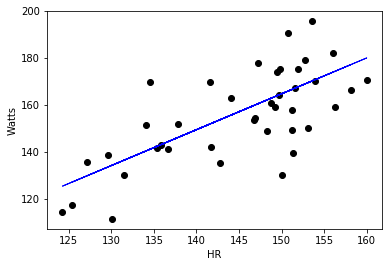

Slope:       14.554808
Interceptor: 156.726898


In [426]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Input, Dense
from keras.models import Model

import numpy as np

# Normalize
sc = StandardScaler()

qw = t_data["watts"].quantile(0.02)
cur = t_data[t_data['watts'] > qw]

x_ = cur['hr']
y_ = cur['watts']

x = x_
x = sc.fit_transform(x_.values.reshape(-1, 1))
y = y_
# y = sc.fit_transform(y_.values.reshape(-1, 1))

# Model
inputs = Input(shape=(1,))
preds = Dense(1, activation='linear')(inputs)

model = Model(inputs=inputs,outputs=preds)
sgd = keras.optimizers.SGD()

model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])
model.fit(x,y, batch_size=1, epochs=30, shuffle=False, verbose=0)

# Plot
plt.figure()
plt.scatter(x_,y, color='black')

plt.xlabel('HR')
plt.ylabel('Watts')

plt.plot(x_, model.predict(x), color='blue', linewidth=1)

plt.show()

slope = model.get_weights()[0].item(0)
interceptor = model.get_weights()[1].item(0)

print("Slope:       %f" % slope)
print("Interceptor: %f" % interceptor)

In [427]:
pr_hr = 160

norm_hr = sc.transform(np.array([pr_hr]).reshape(-1, 1))
a = model.predict(norm_hr).item(0)

print("%f (%f) -> %f watts" % (pr_hr, norm_hr, a))

160.000000 (1.597836) -> 179.983093 watts


# Clustering over most features

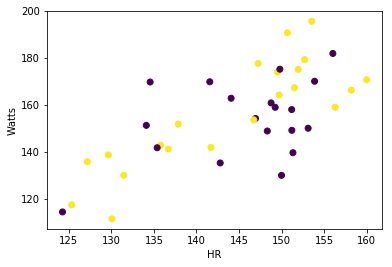

In [428]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
qw = t_data["watts"].quantile(0.03)
cur = t_data[t_data['watts'] > qw]

k_means = cluster.KMeans(n_clusters=2)
k_means.fit(cur.drop(['filename', 'kph', 'watts_75', 'watts_25', 'watts_50', 'lrbalance'], axis=1))

cur = cur.assign(c=k_means.labels_)

plt.scatter(x_, y_, c=cur['c'])

plt.xlabel('HR')
plt.ylabel('Watts')

plt.show()

In [429]:
cur[cur['c'] == 1].describe().drop(['count']).drop(['kph', 'lrbalance', 'c'], axis=1)

,cad,hr,hr_drift,kilojoules,watts,watts_std,watts_25,watts_50,watts_75,np,temp,if
mean,74.961002,143.991587,0.143134,645.480905,156.414581,81.995342,107.464286,171.428571,212.000000,203.141595,23.200322,1.309291
std,3.779309,10.894467,0.156189,189.146422,22.845151,10.948336,33.929549,29.828797,26.248809,23.687826,5.347293,0.130922
min,64.526207,125.341384,-0.193761,116.413000,111.506705,53.927852,0.000000,97.000000,165.000000,153.922556,14.006589,1.133115
25%,72.709305,135.782489,0.064966,616.146000,141.203424,76.543053,98.000000,152.000000,191.000000,184.799407,18.667380,1.239362
50%,75.567260,147.241957,0.159638,696.752000,158.979282,84.460239,108.000000,174.000000,219.000000,212.767175,23.637290,1.289211
75%,77.125034,151.950993,0.211377,764.523500,173.900683,88.269054,123.500000,194.000000,235.000000,219.968125,26.435464,1.342407
max,80.856345,160.003281,0.498792,874.076500,195.580327,103.946924,164.000000,217.000000,246.000000,233.142459,31.812261,1.702657


In [430]:
cur[cur['c'] == 0].describe().drop(['count']).drop(['kph', 'lrbalance', 'c'], axis=1)

,cad,hr,hr_drift,kilojoules,watts,watts_std,watts_25,watts_50,watts_75,np,temp,if
mean,73.017440,145.607357,0.152181,1205.978605,153.805849,85.855072,104.750000,167.684211,208.578947,209.232641,24.264300,1.367842
std,5.780358,8.298162,0.135084,243.387748,16.770337,9.686247,28.262043,20.763356,18.179096,18.690401,5.255878,0.118159
min,56.689703,124.256308,-0.233285,920.854000,114.462896,71.301331,57.000000,134.000000,168.000000,160.257097,13.787747,1.163818
25%,70.983320,142.176572,0.077842,1029.303750,145.333388,81.813967,84.000000,154.500000,194.500000,201.960688,20.587627,1.282396
50%,73.665895,148.767405,0.181344,1169.916000,154.216066,85.277914,107.000000,168.000000,211.000000,209.517908,24.328665,1.359155
75%,76.862562,151.197228,0.217788,1335.316500,166.284376,89.252226,122.000000,184.500000,220.000000,218.452425,27.287114,1.483001
max,82.102925,156.026180,0.363649,1823.867500,181.884360,107.855181,164.000000,206.000000,237.000000,242.592991,34.711622,1.569161


It seems that the 'differentiating' feature is kilojoules. We can see that the mean of kilojoules is:

* Group 1: 645 kj
* Group 2: 1205 kj

While the rest of the data has similar characteristics

# Regression tree

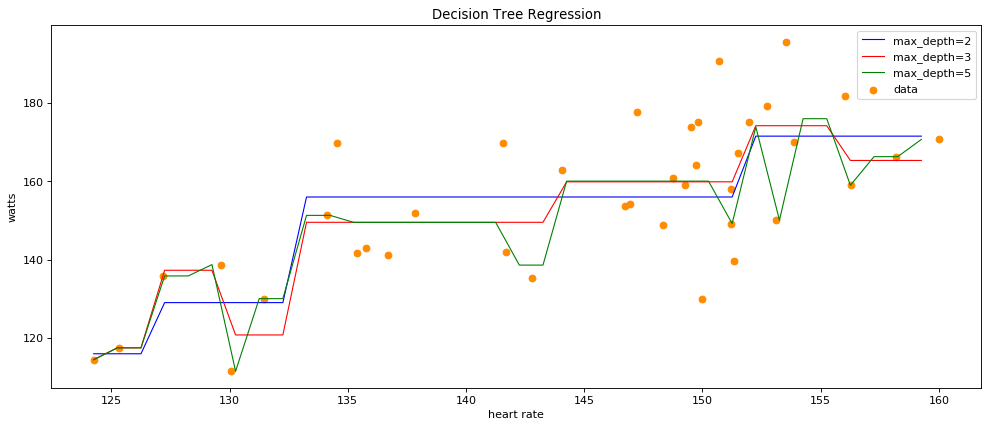

155.000000 bpm Depth 2: 171.522018 watts
155.000000 bpm Depth 3: 174.181928 watts
155.000000 bpm Depth 5: 175.974949 watts


In [575]:
# MLP for Pima Indians Dataset with 10-fold cross validation via sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeRegressor

# Normalize
sc = StandardScaler()

qw = t_data["watts"].quantile(0.02)
cur = t_data[t_data['watts'] > qw]

x_ = cur['hr']
y_ = cur['watts']

X = x_[:, None]
# X = sc.fit_transform(x_.values.reshape(-1, 1))
y = y_
# y = sc.fit_transform(y_.values.reshape(-1, 1))


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=3)
regr_3 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

# Predict
X_test = np.arange(x_.min(), x_.max(), 1)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)

# Plot the results
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(X, y, c="darkorange", label="data")
plt.plot(X_test, y_1, color="blue", label="max_depth=2", linewidth=1)
plt.plot(X_test, y_2, color="red", label="max_depth=3", linewidth=1)
plt.plot(X_test, y_3, color="green", label="max_depth=5", linewidth=1)
plt.xlabel("heart rate")
plt.ylabel("watts")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

pr_hr = 155
p1 = regr_1.predict(pr_hr)
p2 = regr_2.predict(pr_hr)
p3 = regr_3.predict(pr_hr)


print("%f bpm Depth 2: %f watts" % (pr_hr, p1))
print("%f bpm Depth 3: %f watts" % (pr_hr, p2))
print("%f bpm Depth 5: %f watts" % (pr_hr, p3))